In [1]:
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [10]:
path = 'minimal_pkls/'
save_path = 'phi_stats/'
os.makedirs(save_path, exist_ok=True)
files = os.listdir(path)
len(files)

200

In [22]:
from social_phi import get_signal, experiment_hop_range

def flatten(l : list):
    return [item for sublist in l for item in sublist]

def run_experiment(file, time_scale=24*3600, window=30):
    if os.path.exists(save_path + file[:-4] + '.csv'):
        return
    
    data = pickle.load(open(path + file, 'rb'))
    sig = get_signal(data['activities'], time_scale=time_scale, binarize=True)
    stats = experiment_hop_range(sig=sig, window=window, min_hop=1, max_hop=window, silent=True)
    stats.to_csv(save_path + file[:-4] + '.csv', index=False)
    
def load_data(file, key='vnr'):
    stats = pd.read_csv(save_path + file)
    data = pickle.load(open(path + file[:-4] + '.pkl', 'rb'))
    act = flatten(data['activities'].values())
    
    return {
        'forks' : data['forks'],
        'stars' : data['stars'],
        'issues' : data['issues'],
        'users' : len(data['activities']),
        'commits' : len(act),
        'timeline_length' : (max(act) - min(act)) // (24*3600),
        'avg_phi' : max(stats[stats[key] == max(stats[key])]['avg_phi'])
    }

In [7]:
from joblib import Parallel, delayed

_ = Parallel(n_jobs=20)(delayed(extract_data)(file) for file in tqdm(files))

  0%|          | 0/200 [00:00<?, ?it/s]

In [37]:
df = pd.DataFrame(columns=['forks', 'stars', 'issues', 'users', 'commits', 'timeline_length', 'avg_phi'])
for file in os.listdir(save_path):
    df = df.append(load_data(file, key='vnr'), ignore_index=True)
df = df.astype(float)
print(df.shape)
df.describe()

(200, 7)


,forks,stars,issues,users,commits,timeline_length,avg_phi
count,200.000000,200.000000,200.00000,200.000000,200.000000,200.000000,200.000000
mean,7310.725000,34761.095000,763.85500,626.325000,10420.275000,2897.120000,0.791408
std,8987.707573,32779.152061,990.46492,837.297933,5509.547699,1182.043621,0.168434
min,719.000000,15237.000000,0.00000,11.000000,1520.000000,414.000000,0.312381
25%,2934.000000,18782.000000,164.50000,247.000000,6215.250000,2127.000000,0.696622
50%,4426.500000,24287.500000,500.00000,455.500000,8448.000000,2737.000000,0.805669
75%,7774.500000,37941.500000,919.75000,714.500000,13560.750000,3599.250000,0.903137
max,73734.000000,325401.000000,9213.00000,9618.000000,27770.000000,7847.000000,1.273094


In [39]:
df.corr().loc['avg_phi']

forks             -0.018814
stars              0.026867
issues            -0.133095
users             -0.020465
commits           -0.085881
timeline_length    0.113696
avg_phi            1.000000
Name: avg_phi, dtype: float64

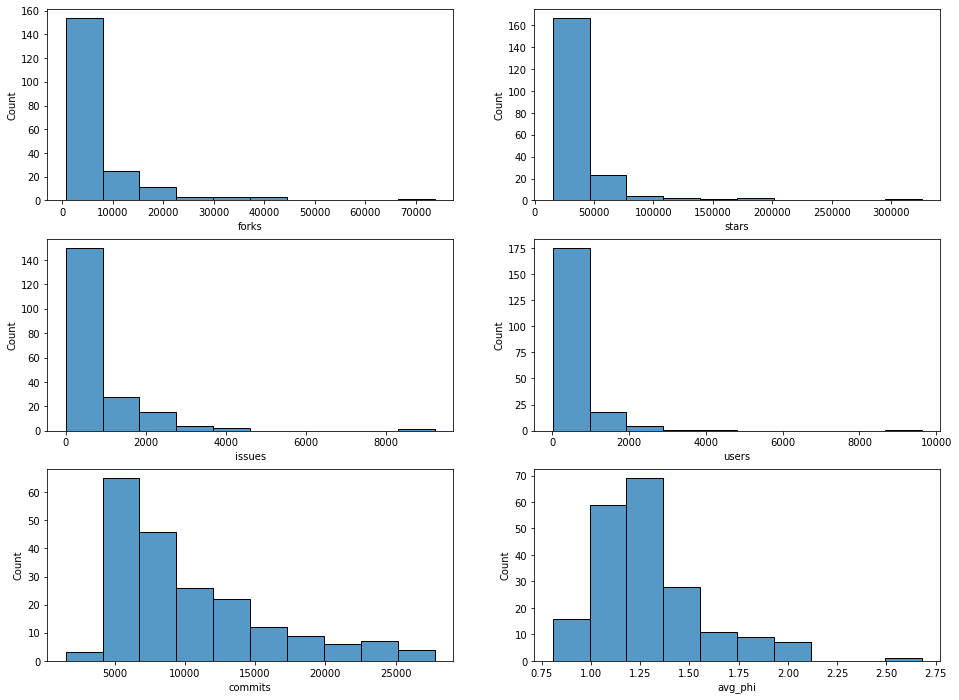

In [34]:
plt.figure(figsize=(16,12))

plt.subplot(3,2,1)
sns.histplot(df['forks'], bins=10)

plt.subplot(3,2,2)
sns.histplot(df['stars'], bins=10)

plt.subplot(3,2,3)
sns.histplot(df['issues'], bins=10)

plt.subplot(3,2,4)
sns.histplot(df['users'], bins=10)

plt.subplot(3,2,5)
sns.histplot(df['commits'], bins=10)

plt.subplot(3,2,6)
sns.histplot(df['avg_phi'], bins=10)

plt.show()

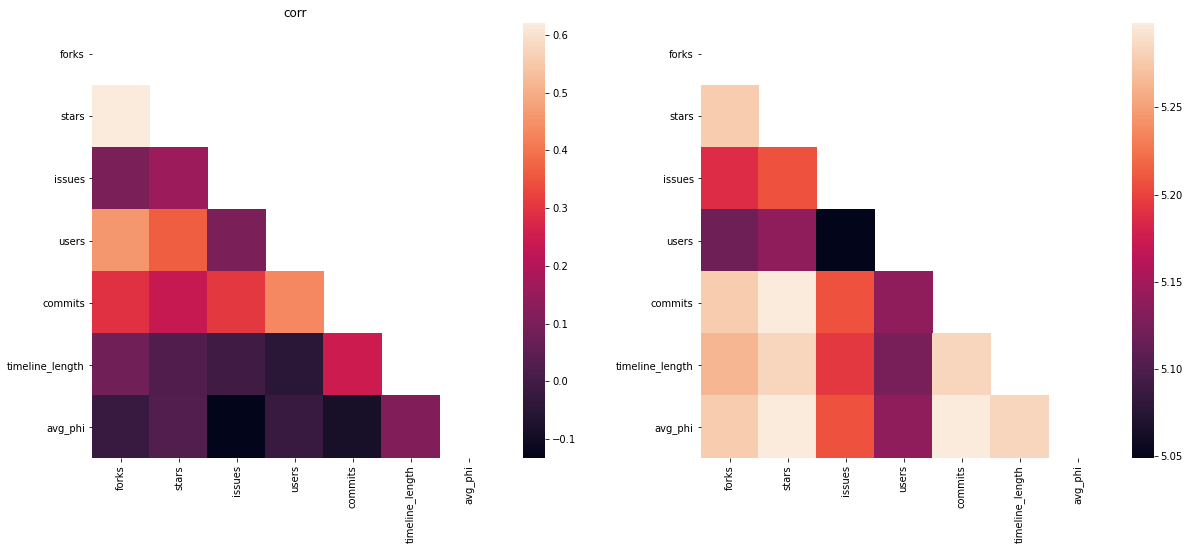

In [41]:
from sklearn.metrics import mutual_info_score, normalized_mutual_info_score, adjusted_mutual_info_score

plt.figure(figsize=(20,8))
plt.subplot(1,2,1)
plt.title('corr')
sns.heatmap(df.corr(), mask=np.triu(np.ones(df.shape[1])))

mis = np.zeros(shape=(df.shape[1], df.shape[1]))
for i in range(df.shape[1]):
    for j in range(df.shape[1]):
        mis[i,j] = mutual_info_score(df[df.columns[i]], df[df.columns[j]])
mis = pd.DataFrame(mis, columns=df.columns, index=df.columns)

plt.subplot(1,2,2)
sns.heatmap(mis, mask=np.triu(np.ones(df.shape[1])))
plt.show()

In [43]:
mis.loc['avg_phi']

forks              5.277523
stars              5.298317
issues             5.208208
users              5.138894
commits            5.298317
timeline_length    5.284454
avg_phi            5.298317
Name: avg_phi, dtype: float64

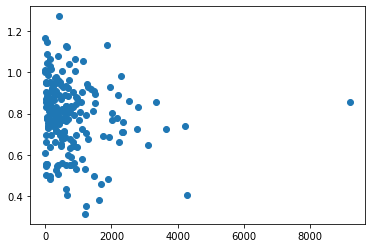

In [31]:
plt.scatter(x=df['issues'], y=df['avg_phi'])

In [43]:
# from social_phi import get_single_signal

# def display_growth(col):
#     for data in all_data:
#         sig, _, _ = get_single_signal(data[col], time_scale=24*3600, binarize=False)
#         cum_sig = [sig[:i+1].sum() for i in range(len(sig))]
#         plt.plot(cum_sig)
        
# def display_commit_growth():
#     for data in all_data:
#         act = flatten(data['activities'].values())
#         sig, _, _ = get_single_signal(act, time_scale=24*3600, binarize=False)
#         cum_sig = [sig[:i+1].sum() for i in range(len(sig))]
#         plt.plot(cum_sig)

# plt.figure(figsize=(16,16))

# plt.subplot(4,1,1)
# plt.title('forks')
# display_growth('forks')

# plt.subplot(4,1,2)
# plt.title('stars')
# display_growth('stars')

# plt.subplot(4,1,3)
# plt.title('issues')
# display_growth('issues')

# plt.subplot(4,1,4)
# plt.title('commits')
# display_commit_growth()
    
# plt.show()